# Time Series analysis of CPI

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Data Read

In [31]:
"""
Dataset from: https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/d7g7/mm23

"""

#data is read and original date time string converted to date time object.
df = pd.read_csv("cpiData.csv",parse_dates=["date"], index_col="date") #edit the file path here to read the provided dataset.
df.head()

,cpi
date,
1988-02-01,0.3
1988-03-01,0.3
1988-04-01,1.2
1988-05-01,0.5
1988-06-01,0.4


# Exploratory Data Analysis

,cpi,year
count,410.000000,410.000000
mean,0.216341,2004.668293
std,0.406188,9.877599
min,-0.900000,1988.000000
25%,0.000000,1996.000000
50%,0.300000,2005.000000
75%,0.400000,2013.000000
max,3.300000,2022.000000


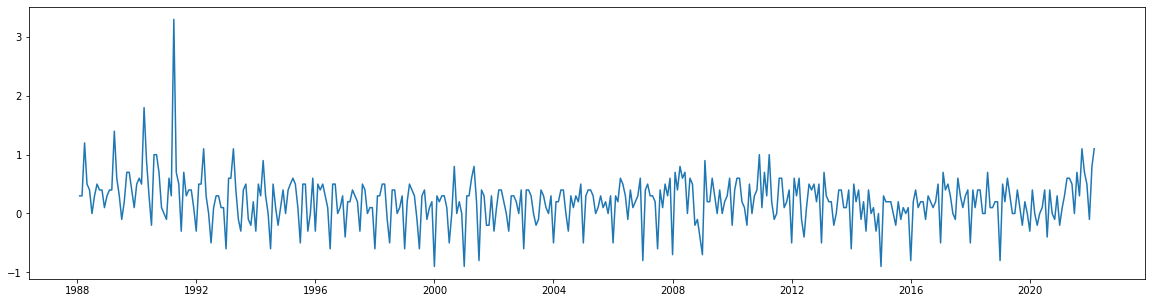

In [55]:
#Produces a plot of the whole timeseries.
fig, (ax1) = plt.subplots(nrows=1)
fig.set_size_inches(20, 5)
plt.plot(df["cpi"])


<AxesSubplot:xlabel='month', ylabel='cpi'>

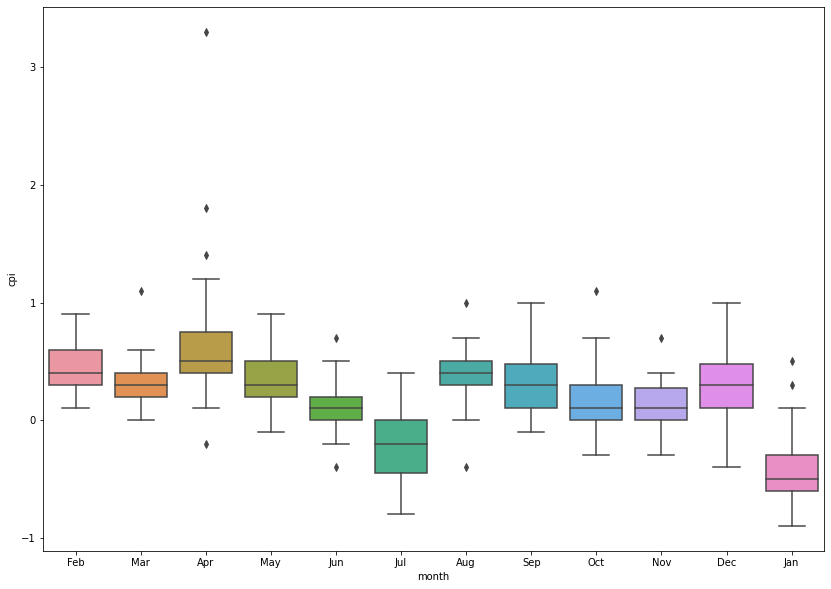

In [34]:
#subset boxplot by month
df["year"] = [d.year for d in df.index]
df['month'] = [d.strftime("%b") for d in df.index]
years = df["year"].unique()

plt.figure(figsize=(14, 10))
#month boxplot
sns.boxplot(x="month", y="cpi", data=df)

In [35]:
# adfuller test fo stationarity
from statsmodels.tsa.stattools import adfuller

adf, pvalue,usedlag_, nobs_, critical_values_, icbest_ = adfuller(df["cpi"])
print("pvalue = ", pvalue)

pvalue =  0.1997534244253238


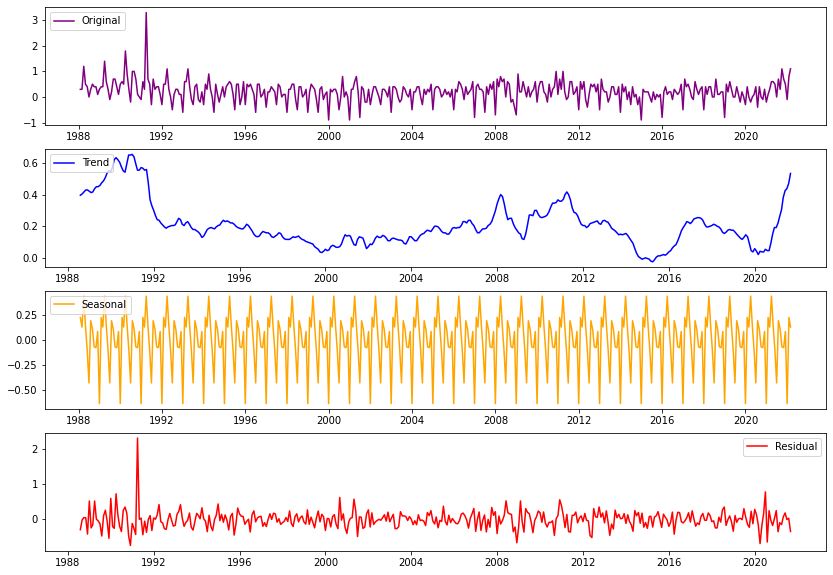

In [36]:
#Extract and plot trend, seasonal and residuals.
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df["cpi"], model = "additive")

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df["cpi"], label="Original", color="purple")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(trend, label="Trend", color="blue")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(seasonal, label="Seasonal", color="orange")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(residual, label="Residual", color="red")
plt.legend(loc="upper right")
plt.show()

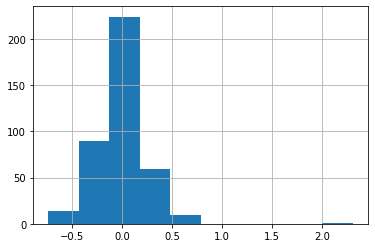

In [37]:
#normality of the residuals provides assurance that the timeseries was decomposed effectively.
hist = residual.hist()

# SARIMA MODEL FIT

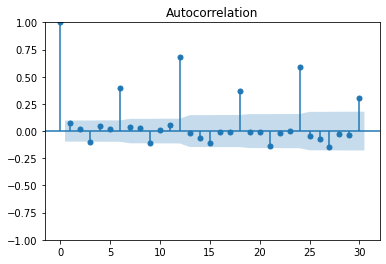

c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


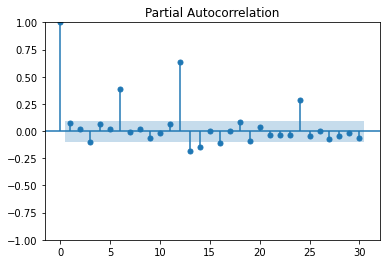

In [39]:
#ACF and PACF plots used to narrow the sarch or the best model.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df["cpi"], lags=30)
plt.show()

plot_pacf(df["cpi"], lags=30)
plt.show()

In [40]:
#auto arime is employed to produce an estimate for the best Sarima model.
 
from pmdarima.arima import auto_arima
from pmdarima.arima import StepwiseContext

arima_model = auto_arima(
    df["cpi"], start_p=1, start_q=1,
    max_p=2, max_q=2, max_d=1, m=12,
    start_P=0, start_Q=0, max_P=5, max_D=5,
    max_Q=5, seasonal=True, trace=True,
    error_action="ignore", suppress_warnings= True,
    stepwise="True", n_fits=50
    )


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=420.737, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=678.087, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=262.692, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=259.903, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=676.092, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=418.737, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=95.457, Time=1.58 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=158.457, Time=0.70 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=97.258, Time=2.90 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=93.697, Time=3.47 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=230.425, Time=1.55 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=89.640, Time=3.95 sec
 ARIMA(0,1,1)(3,0,2)[12] intercept   : AIC=91.689, Time=8.15 sec
 ARIMA(0,1,1)(2,0,3)[12] intercept   : AIC=92.473, Time=9.44 sec
 ARIMA(0,1,1)(1,0,3)[12] intercept   : 

In [41]:
# details of the best model are given in this summary
print(arima_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  410
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 -37.820
Date:                                 Thu, 19 May 2022   AIC                             89.640
Time:                                         17:51:16   BIC                            117.736
Sample:                                              0   HQIC                           100.756
                                                 - 410                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.241      0.810      -0.001       0

In [45]:
#train and test sets are created here.
train_size = int(len(df)*0.66)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]
train

,cpi,year,month
date,,,
1988-02-01,0.3,1988,Feb
1988-03-01,0.3,1988,Mar
1988-04-01,1.2,1988,Apr
1988-05-01,0.5,1988,May
1988-06-01,0.4,1988,Jun
...,...,...,...
2010-03-01,0.6,2010,Mar
2010-04-01,0.6,2010,Apr
2010-05-01,0.2,2010,May


In [59]:
#the model is trained on the test set, the configuration is taken from the autoarima sumamry above.
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train["cpi"],
    order=(0, 1, 1),
    seasonal_order=(2, 0, 1, 12)
)

model = model.fit()

c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


# Sarima Model Test

<AxesSubplot:xlabel='date'>

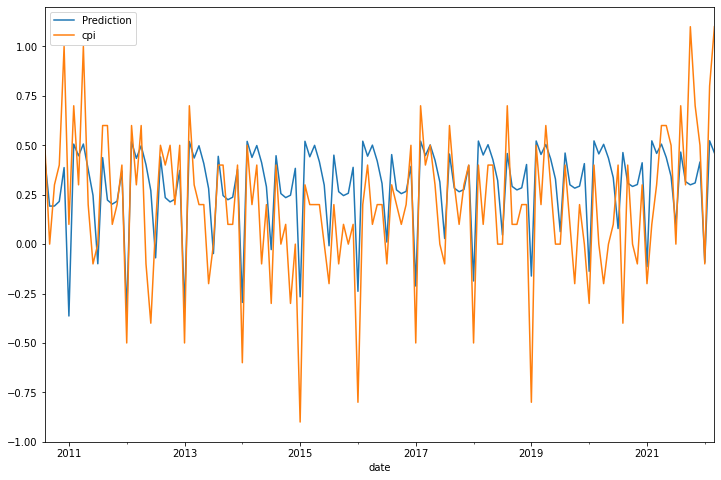

In [63]:
#Train Prediction
start = 0
end = len(train) -1
train_prediction = model.predict(start=start, end=end)

#Test Prediction
start = len(train)
end = len(df) - 1
prediction = model.predict(start=start, end=end).rename("Prediction")

#Test plot
plt.figure(figsize=(12, 8))
prediction.plot(legend=True)
test["cpi"].plot(legend=True)




In [64]:
#produce R^2 score
from sklearn.metrics import r2_score
score = r2_score(test['cpi'], prediction)
print("R2 score is: ", score)

import math
from sklearn.metrics import mean_squared_error

train_score = math.sqrt(mean_squared_error(train["cpi"], train_prediction))
print("Train Score: %2f RMSE" % (train_score))
test_score = math.sqrt(mean_squared_error(test["cpi"], prediction))
print("Test Score: %.2f RMSE" % (test_score))

R2 score is:  0.3542282505054396
Train Score: 0.275609 RMSE
Test Score: 0.28 RMSE
